In [1]:
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import cm
from matplotlib import pyplot as plt
from bancs import BANCS, DrawFunctions

In [2]:
from matplotlib import rc, rcParams, style
#style.use('default')
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
rc('font', **{'family': 'Times'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

## Parabolic 2 reliability problem

In [3]:
g = ot.SymbolicFunction(["x1", "x2"], ["(x1 - x2) ^ 2 - 8 * (x1 + x2 - 5)"])

In [4]:
X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2, ot.GumbelCopula(3.))
#X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
threshold = 0.
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
# Reference computed using CMC with subset size N=1e7
pf_ref = 0.0001315399999999369

In [5]:
#initialNumberOfCall = g.getEvaluationCallsNumber()
#Nref = int(1e7)
#experiment = ot.MonteCarloExperiment()
#algoMC = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)
#algoMC.setMaximumCoefficientOfVariation(0.001)
#algoMC.setMaximumOuterSampling(Nref)
#algoMC.setBlockSize(10)
#algoMC.run()
#numberOfFunctionEvaluations = (g.getEvaluationCallsNumber() - initialNumberOfCall)
#print("{:.3e}".format(numberOfFunctionEvaluations))
#print(algoMC.getResult().getProbabilityEstimate())

## BANCS : Bernstein Adaptive Nonparametric Conditional Sampling

In [6]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
greys = mpl.colormaps['Greys_r']
faded_greys = ListedColormap(greys(np.linspace(0.4, 1, 128)))

Quantiles = [19.94879744  3.85190177 -6.78773895]
Proba EBC = 5.68e-03
Relative error = 4215.60%


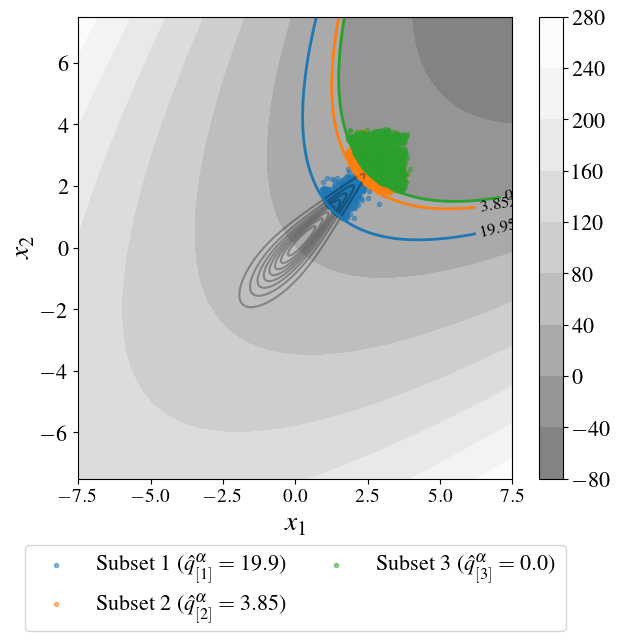

In [7]:
N = int(1e4)
bancs = BANCS(failure_event, N=N, M=10, p0=0.1)
quantiles = bancs.run()
pf = bancs.compute_pf()
print("Quantiles =", quantiles)
print("Proba EBC = {:.2e}".format(pf))
print("Relative error = {:.2%}".format(np.abs(pf - pf_ref) / pf_ref))
fig = bancs.draw_2D_BANCS(colorbar=faded_greys)
plt.savefig("figures/bancs_parabolic2.pdf", bbox_inches='tight')
plt.savefig("figures/bancs_parabolic2.jpg", bbox_inches='tight', dpi=300);

In [8]:
ss_index = 2
failed_sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==ss_index)][bancs.xlabels].values

In [9]:
bancs.fail_operator(bancs.df.loc[bancs.df["Subset"]==1, "Y"].values, bancs.df.loc[bancs.df["Subset"]==2, "Quantile"].values).shape

(10000,)

In [10]:
for k in range(ss_index): 
    failed_bool = bancs.fail_operator(bancs.df.loc[bancs.df["Subset"]==k, "Y"].values, bancs.df.loc[bancs.df["Subset"]==ss_index, "Quantile"].values)
    sub_df = bancs.df.loc[bancs.df["Subset"]==k]
    weighted_failed_sample = sub_df[(failed_bool)][bancs.xlabels].values
    nb_reps = np.floor((ss_index - k) / bancs.p0)
    weighted_failed_sample = np.repeat(weighted_failed_sample, nb_reps, axis=0)
    failed_sample = np.vstack([failed_sample, weighted_failed_sample])

In [11]:
weighted_failed_sample.shape

(610, 2)